In [ ]:
#! az login

In [ ]:
# Inspector
# npx @modelcontextprotocol/inspector

# MCP Server with Responses API

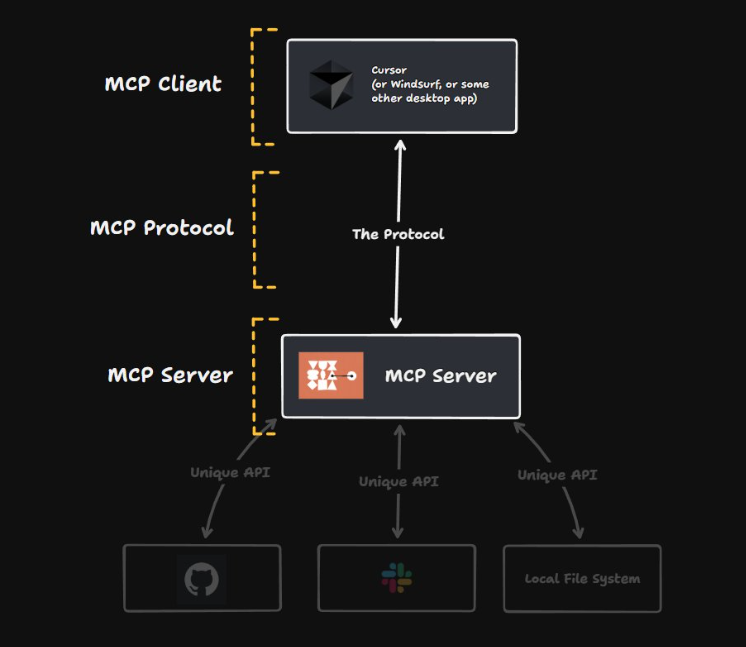

## Microsoft Learn MCP Server with Responses API

In [1]:
#Only works for remote MCP servers (so no local deployed)
from openai import AzureOpenAI
from azure.identity import DefaultAzureCredential, get_bearer_token_provider

token_provider = get_bearer_token_provider(
    DefaultAzureCredential(), "https://cognitiveservices.azure.com/.default"
)

client = AzureOpenAI(
  azure_endpoint = "https://aifsweden.openai.azure.com/", 
  azure_ad_token_provider=token_provider,
  api_version="2025-03-01-preview"
)

response = client.responses.create(
    model="gpt-5-mini",
    tools=[
         {
            "type": "mcp",
            "server_label": "microsoftlearn",
            "server_url": "https://learn.microsoft.com/api/mcp",
            "require_approval": "never",
         },
    ]
,
    input="Tall me about the types of models in AI Foundry. Only use the MCP tool to get the information, do not use the model. Create a full list - do not miss any out. List the features with the link next to each one",
)

print(response.output_text)



Below is a comprehensive list of the model types (categories and capability types) described in Microsoft Foundry Models (AI Foundry), with key features and a Microsoft Learn link for each item. All items and features are taken from Microsoft documentation.

1) Foundation models  
- Features: large pretrained base models used as general-purpose starting points for many tasks; available from multiple providers in the Foundry catalog.  
- Link: https://learn.microsoft.com/en-us/azure/ai-foundry/concepts/foundry-models-overview?view=foundry-classic

2) Reasoning models (advanced/problem‑solving models; e.g., o‑series)  
- Features: optimized for multi-step reasoning and complex problem solving, larger context windows, used for high‑focus reasoning tasks.  
- Link: https://learn.microsoft.com/en-us/azure/ai-foundry/foundry-models/concepts/models-sold-directly-by-azure?view=foundry-classic#azure-openai-in-microsoft-foundry-models

3) Small language models (SLMs)  
- Features: lightweight mo

In [27]:
import time
from datetime import datetime, timezone
from openai import AzureOpenAI
from azure.identity import DefaultAzureCredential, get_bearer_token_provider

# ---------- Helpers ----------
def now_monotonic():
    """High-resolution timer for duration calculations."""
    return time.perf_counter()

def ts_utc():
    """Wall-clock timestamp for logs."""
    return datetime.now(timezone.utc).isoformat(timespec="milliseconds")

def ms(delta):
    """Format seconds as milliseconds string."""
    return f"{int(delta * 1000)} ms"

def print_kv(label, value):
    print(f"{label:32s}: {value}")

# ---------- Azure AD (Entra ID) token provider ----------
token_provider = get_bearer_token_provider(
    DefaultAzureCredential(), "https://cognitiveservices.azure.com/.default"
)

client = AzureOpenAI(
    azure_endpoint="https://aifsweden.openai.azure.com/",
    azure_ad_token_provider=token_provider,
    api_version="2025-03-01-preview",
)

# ---------- Request ----------
model = "gpt-5-mini"  # replace with your deployed model name

tools = [
    {
        "type": "mcp",
        "server_label": "microsoftlearn",
        "server_url": "https://learn.microsoft.com/api/mcp",
        "require_approval": "never",
    }
]

prompt = (
    "What are the Responsible AI principles? Only use the MCP Server to get the information, do not use the model."
)

# ---------- Streaming call with phase timing ----------
t0 = now_monotonic()
phase = {
    "response.created": None,
    "first.output_item": None,        # any output item
    "first.text.delta": None,         # first text token
    "mcp.list.start": None,
    "mcp.list.done": None,
    "mcp.approval.start": None,
    "mcp.approval.done": None,        # when approval UI item completes rendering
    "mcp.call.start": None,
    "mcp.call.done": None,
    "response.completed": None,
}

# Accumulate the final text for convenience (optional)
final_text_chunks = []

# Start streaming
stream = client.responses.create(
    model=model,
    tools=tools,
    input=prompt,
    stream=True,
)

print("\n=== Streaming started ===")
for event in stream:
    # Capture a monotonic timestamp for durations
    now = now_monotonic()

    etype = getattr(event, "type", None)

    # 1) Response lifecycle
    if etype == "response.created":
        if phase["response.created"] is None:
            phase["response.created"] = now
            print_kv("response.created (UTC)", ts_utc())

    elif etype == "response.output_item.added":
        # First output item (text, tool discovery, tool call, etc.)
        if phase["first.output_item"] is None:
            phase["first.output_item"] = now
            print_kv("first.output_item (UTC)", ts_utc())

        # Identify MCP phases by item.type if available
        item = getattr(event, "item", None)
        item_type = getattr(item, "type", None)
        if item_type == "mcp_list_tools" and phase["mcp.list.start"] is None:
            phase["mcp.list.start"] = now
            print_kv("mcp_list_tools.start (UTC)", ts_utc())
        elif item_type == "mcp_approval_request" and phase["mcp.approval.start"] is None:
            phase["mcp.approval.start"] = now
            print_kv("mcp_approval_request.start (UTC)", ts_utc())
        elif item_type == "mcp_call" and phase["mcp.call.start"] is None:
            phase["mcp.call.start"] = now
            print_kv("mcp_call.start (UTC)", ts_utc())

    elif etype == "response.output_text.delta":
        # First text token
        if phase["first.text.delta"] is None:
            phase["first.text.delta"] = now
            print_kv("first.text.delta (UTC)", ts_utc())
        # Accumulate text (optional)
        delta = getattr(event, "delta", None)
        if delta:
            final_text_chunks.append(delta)

    elif etype == "response.output_item.done":
        # Done events for specific items (MCP phases)
        item = getattr(event, "item", None)
        item_type = getattr(item, "type", None)
        if item_type == "mcp_list_tools":
            phase["mcp.list.done"] = now
            print_kv("mcp_list_tools.done (UTC)", ts_utc())
        elif item_type == "mcp_approval_request":
            phase["mcp.approval.done"] = now
            print_kv("mcp_approval_request.done (UTC)", ts_utc())
        elif item_type == "mcp_call":
            phase["mcp.call.done"] = now
            print_kv("mcp_call.done (UTC)", ts_utc())

    elif etype == "response.completed":
        phase["response.completed"] = now
        print_kv("response.completed (UTC)", ts_utc())

    elif etype == "error":
        # Optional: print or handle errors
        print("\n[ERROR EVENT]")
        print(event)

print("=== Streaming finished ===\n")

# ---------- Latency Summary ----------
base = phase["response.created"] or t0

summary = {
    "TTFB (response.created)": ms((phase["response.created"] or base) - t0),
    "Time to first output item": (
        ms(phase["first.output_item"] - base) if phase["first.output_item"] else "n/a"
    ),
    "Time to first text delta": (
        ms(phase["first.text.delta"] - base) if phase["first.text.delta"] else "n/a"
    ),
    "MCP list_tools duration": (
        ms(phase["mcp.list.done"] - phase["mcp.list.start"])
        if phase["mcp.list.start"] and phase["mcp.list.done"]
        else "n/a"
    ),
    "MCP approval UI latency": (
        ms(phase["mcp.approval.done"] - phase["mcp.approval.start"])
        if phase["mcp.approval.start"] and phase["mcp.approval.done"]
        else "n/a"
    ),
    "MCP call duration": (
        ms(phase["mcp.call.done"] - phase["mcp.call.start"])
        if phase["mcp.call.start"] and phase["mcp.call.done"]
        else "n/a"
    ),
    "End-to-end (completed)": (
        ms((phase["response.completed"] or now_monotonic()) - t0)
    ),
}

print("=== Latency Summary ===")
for k, v in summary.items():
    print_kv(k, v)

# ---------- Final text (optional pretty-print) ----------
final_text = "".join(final_text_chunks).strip()
if final_text:
    print("\n=== Model Output (assembled) ===")



=== Streaming started ===
response.created (UTC)          : 2025-11-24T11:18:27.151+00:00
first.output_item (UTC)         : 2025-11-24T11:18:27.178+00:00
mcp_list_tools.start (UTC)      : 2025-11-24T11:18:27.178+00:00
mcp_list_tools.done (UTC)       : 2025-11-24T11:18:28.767+00:00
mcp_call.start (UTC)            : 2025-11-24T11:18:31.241+00:00
mcp_call.done (UTC)             : 2025-11-24T11:18:32.210+00:00
mcp_call.done (UTC)             : 2025-11-24T11:18:37.057+00:00
first.text.delta (UTC)          : 2025-11-24T11:18:38.250+00:00
response.completed (UTC)        : 2025-11-24T11:18:40.480+00:00
=== Streaming finished ===

=== Latency Summary ===
TTFB (response.created)         : 2966 ms
Time to first output item       : 27 ms
Time to first text delta        : 11099 ms
MCP list_tools duration         : 1589 ms
MCP approval UI latency         : n/a
MCP call duration               : 5817 ms
End-to-end (completed)          : 16295 ms

=== Model Output (assembled) ===


In [31]:
import time
from datetime import datetime, timezone
from openai import AzureOpenAI
from azure.identity import DefaultAzureCredential, get_bearer_token_provider

# ---------- Helpers ----------
def now_monotonic():
    """High-resolution timer for duration calculations."""
    return time.perf_counter()

def ts_utc():
    """Wall-clock timestamp for logs."""
    return datetime.now(timezone.utc).isoformat(timespec="milliseconds")

def ms(delta):
    """Format seconds as milliseconds string."""
    return f"{int(delta * 1000)} ms"

def print_kv(label, value):
    print(f"{label:32s}: {value}")

# ---------- Azure AD (Entra ID) token provider ----------
token_provider = get_bearer_token_provider(
    DefaultAzureCredential(), "https://cognitiveservices.azure.com/.default"
)

client = AzureOpenAI(
    azure_endpoint="https://aifsweden.openai.azure.com/",
    azure_ad_token_provider=token_provider,
    api_version="2025-03-01-preview",
)

# ---------- Request ----------
model = "gpt-5-mini"  # replace with your deployed model name

tools = [
    {
        "type": "mcp",
        "server_label": "DNDMCPServer",
        "server_description": "A Dungeons and Dragons MCP server to assist with dice rolling.",
        "server_url": "https://dmcp-server.deno.dev/sse",
        # Change to "always" to force approval and exercise the approval path
        "require_approval": "never",
    }
]

prompt = (
    "Roll 3 d20s for me"
)

# ---------- Streaming call with phase timing ----------
t0 = now_monotonic()
phase = {
    "response.created": None,
    "first.output_item": None,        # any output item
    "first.text.delta": None,         # first text token
    "mcp.list.start": None,
    "mcp.list.done": None,
    "mcp.approval.start": None,
    "mcp.approval.done": None,        # when approval UI item completes rendering
    "mcp.call.start": None,
    "mcp.call.done": None,
    "response.completed": None,
}

# Accumulate the final text for convenience (optional)
final_text_chunks = []

# Start streaming
stream = client.responses.create(
    model=model,
    tools=tools,
    input=prompt,
    stream=True,
)

print("\n=== Streaming started ===")
for event in stream:
    # Capture a monotonic timestamp for durations
    now = now_monotonic()

    etype = getattr(event, "type", None)

    # 1) Response lifecycle
    if etype == "response.created":
        if phase["response.created"] is None:
            phase["response.created"] = now
            print_kv("response.created (UTC)", ts_utc())

    elif etype == "response.output_item.added":
        # First output item (text, tool discovery, tool call, etc.)
        if phase["first.output_item"] is None:
            phase["first.output_item"] = now
            print_kv("first.output_item (UTC)", ts_utc())

        # Identify MCP phases by item.type if available
        item = getattr(event, "item", None)
        item_type = getattr(item, "type", None)
        if item_type == "mcp_list_tools" and phase["mcp.list.start"] is None:
            phase["mcp.list.start"] = now
            print_kv("mcp_list_tools.start (UTC)", ts_utc())
        elif item_type == "mcp_approval_request" and phase["mcp.approval.start"] is None:
            phase["mcp.approval.start"] = now
            print_kv("mcp_approval_request.start (UTC)", ts_utc())
        elif item_type == "mcp_call" and phase["mcp.call.start"] is None:
            phase["mcp.call.start"] = now
            print_kv("mcp_call.start (UTC)", ts_utc())

    elif etype == "response.output_text.delta":
        # First text token
        if phase["first.text.delta"] is None:
            phase["first.text.delta"] = now
            print_kv("first.text.delta (UTC)", ts_utc())
        # Accumulate text (optional)
        delta = getattr(event, "delta", None)
        if delta:
            final_text_chunks.append(delta)

    elif etype == "response.output_item.done":
        # Done events for specific items (MCP phases)
        item = getattr(event, "item", None)
        item_type = getattr(item, "type", None)
        if item_type == "mcp_list_tools":
            phase["mcp.list.done"] = now
            print_kv("mcp_list_tools.done (UTC)", ts_utc())
        elif item_type == "mcp_approval_request":
            phase["mcp.approval.done"] = now
            print_kv("mcp_approval_request.done (UTC)", ts_utc())
        elif item_type == "mcp_call":
            phase["mcp.call.done"] = now
            print_kv("mcp_call.done (UTC)", ts_utc())

    elif etype == "response.completed":
        phase["response.completed"] = now
        print_kv("response.completed (UTC)", ts_utc())

    elif etype == "error":
        # Optional: print or handle errors
        print("\n[ERROR EVENT]")
        print(event)

print("=== Streaming finished ===\n")

# ---------- Latency Summary ----------
base = phase["response.created"] or t0

summary = {
    "TTFB (response.created)": ms((phase["response.created"] or base) - t0),
    "Time to first output item": (
        ms(phase["first.output_item"] - base) if phase["first.output_item"] else "n/a"
    ),
    "Time to first text delta": (
        ms(phase["first.text.delta"] - base) if phase["first.text.delta"] else "n/a"
    ),
    "MCP list_tools duration": (
        ms(phase["mcp.list.done"] - phase["mcp.list.start"])
        if phase["mcp.list.start"] and phase["mcp.list.done"]
        else "n/a"
    ),
    "MCP approval UI latency": (
        ms(phase["mcp.approval.done"] - phase["mcp.approval.start"])
        if phase["mcp.approval.start"] and phase["mcp.approval.done"]
        else "n/a"
    ),
    "MCP call duration": (
        ms(phase["mcp.call.done"] - phase["mcp.call.start"])
        if phase["mcp.call.start"] and phase["mcp.call.done"]
        else "n/a"
    ),
    "End-to-end (completed)": (
        ms((phase["response.completed"] or now_monotonic()) - t0)
    ),
}

print("=== Latency Summary ===")
for k, v in summary.items():
    print_kv(k, v)

# ---------- Final text (optional pretty-print) ----------
final_text = "".join(final_text_chunks).strip()
if final_text:
    print("\n=== Model Output (assembled) ===")


print(final_text)



=== Streaming started ===
response.created (UTC)          : 2025-11-24T11:24:26.604+00:00
first.output_item (UTC)         : 2025-11-24T11:24:26.635+00:00
mcp_list_tools.start (UTC)      : 2025-11-24T11:24:26.635+00:00
mcp_list_tools.done (UTC)       : 2025-11-24T11:24:28.198+00:00
mcp_call.start (UTC)            : 2025-11-24T11:24:31.317+00:00
mcp_call.done (UTC)             : 2025-11-24T11:24:32.333+00:00
mcp_call.done (UTC)             : 2025-11-24T11:25:35.676+00:00
first.text.delta (UTC)          : 2025-11-24T11:25:39.600+00:00
response.completed (UTC)        : 2025-11-24T11:25:40.183+00:00
=== Streaming finished ===

=== Latency Summary ===
TTFB (response.created)         : 2735 ms
Time to first output item       : 32 ms
Time to first text delta        : 72996 ms
MCP list_tools duration         : 1562 ms
MCP approval UI latency         : n/a
MCP call duration               : 64359 ms
End-to-end (completed)          : 76315 ms

=== Model Output (assembled) ===
Rolled 3d20: total =

# Remote MCP with Foundry Agent V1

In [2]:
import time
import json
from azure.ai.agents.models import MessageTextContent, ListSortOrder, McpTool
from azure.ai.projects import AIProjectClient
from azure.identity import DefaultAzureCredential

client = AIProjectClient(
    endpoint="https://aifsweden.services.ai.azure.com/api/projects/AIFSwedenProject01",
    credential=DefaultAzureCredential(),  # Use Azure Default Credential for authentication
)

mcp_tool = McpTool(
    server_label="microsoftlearn",
    server_url="https://learn.microsoft.com/api/mcp",
    allowed_tools=["microsoft_docs_search"],  # Optional: specify allowed tools
)

print(f"Allowed tools: {mcp_tool.allowed_tools}")

agent = client.agents.create_agent(
    model="gpt-4.1-mini", 
    name="my-mcp-agent", 
    instructions="You are a helpful agent that can use MCP tools to assist users. Use the available MCP tools to answer questions and perform tasks.",
    tools=mcp_tool.definitions,
)

thread = client.agents.threads.create()

message = client.agents.messages.create(
    thread_id=thread.id, role="user", content="Types of Azure SQl Database.",
)
print(f"Created message, message ID: {message.id}")

# Disable human approval
mcp_tool.set_approval_mode("never")

run = client.agents.runs.create(thread_id=thread.id,
                                agent_id=agent.id,
                                tool_resources=mcp_tool.resources,)

# Poll the run as long as run status is queued or in progress
while run.status in ["queued", "in_progress", "requires_action"]:
    # Wait for a second
    time.sleep(1)
    run = client.agents.runs.get(thread_id=thread.id, run_id=run.id)
    print(f"Run status: {run.status}")
    if run.status == "requires_action":
        print("Run type: " + run.required_action.type)
        # Check if there are any tool calls in the run steps
        run_steps = client.agents.run_steps.list(thread_id=thread.id, run_id=run.id)
        for step in run_steps:
            if step.type == "tool_calls":
                print(f"Tool call found: {step.step_details.tool_calls}")

if run.status == "failed":
    print(f"Run error: {run.last_error}")

run_steps = client.agents.run_steps.list(thread_id=thread.id, run_id=run.id)
for step in run_steps:
    print(f"Run step: {step.id}, status: {step.status}, type: {step.type}")
    if step.type == "tool_calls":
        print(f"Tool call details:")
        for tool_call in step.step_details.tool_calls:
            print(json.dumps(tool_call.as_dict(), indent=2))

messages = client.agents.messages.list(thread_id=thread.id, order=ListSortOrder.ASCENDING)
for data_point in messages:
    last_message_content = data_point.content[-1]
    if isinstance(last_message_content, MessageTextContent):
        print(f"{data_point.role}: {last_message_content.text.value}")

client.agents.delete_agent(agent.id)
print(f"Deleted agent, agent ID: {agent.id}")

Allowed tools: ['microsoft_docs_search']
Created message, message ID: msg_TbQg6EwOoQLGjDg2fqThEKYO
Run status: RunStatus.IN_PROGRESS
Run status: RunStatus.IN_PROGRESS
Run status: RunStatus.IN_PROGRESS
Run status: RunStatus.IN_PROGRESS
Run status: RunStatus.IN_PROGRESS
Run status: RunStatus.IN_PROGRESS
Run status: RunStatus.IN_PROGRESS
Run status: RunStatus.COMPLETED
Run step: step_7ARfRysAitSjgssMqcgyW7af, status: RunStepStatus.COMPLETED, type: RunStepType.MESSAGE_CREATION
Run step: step_qpgOf1c7dosYD31kp6e12gE8, status: RunStepStatus.COMPLETED, type: RunStepType.TOOL_CALLS
Tool call details:
{
  "id": "call_6b3SaRddFIJoUxB5uR8Dszv3",
  "type": "mcp",
  "arguments": "{\"query\":\"Types of Azure SQL Database\",\"question\":\"What are the types of Azure SQL Database?\"}",
  "name": "microsoft_docs_search",
  "server_label": "microsoftlearn",
  "output": "[{\"title\":\"What is Azure SQL?\",\"content\":\"# What is Azure SQL?\\n## Comparison table\\n| Azure SQL Database | Azure SQL Managed 

# Azure Functions

In [ ]:
# Inspector
# npx @modelcontextprotocol/inspector

In [89]:
#List the avilable tools on the MCP server
from mcp import ClientSession
from mcp.client.sse import sse_client
from dotenv import load_dotenv
import os

# Load .env into environment variables
load_dotenv()

# Now you can use os.getenv
mcpkey = os.getenv("mcpdemoral")

server_url = "https://mcpdemoral.azurewebsites.net/runtime/webhooks/mcp/sse?code=" + mcpkey

print("Connecting to SSE server")

# Create the connection via SSE transport
async with sse_client(url=server_url) as streams:
    # Create the client session with the streams
    async with ClientSession(*streams) as session:
        # Initialize the session
        await session.initialize()
        
        tools = await session.list_tools()
        
        print("Available tools:")
        for tool in tools.tools:
            print(f" - {tool.name}: {tool.description}")
            print(tool.inputSchema)
        print("-----")

Connecting to SSE server
Available tools:
 - get_client_id: Returns the client ID.
{'type': 'object', 'properties': {}, 'required': []}
 - get_database_schema: Returns a list of tables from the database.
{'type': 'object', 'properties': {}, 'required': []}
 - Get_pokemon_by_ID: Returns a pokemon by ID.
{'type': 'object', 'properties': {'pokemonID': {'type': 'string', 'description': 'The ID of the Pokémon.'}}, 'required': []}
 - set_client_name_by_id: Sets the client name by ID and returns confirmation.
{'type': 'object', 'properties': {'clientId': {'type': 'string', 'description': 'The ID of the client.'}, 'clientName': {'type': 'string', 'description': 'The name to set for the client.'}}, 'required': []}
-----


In [90]:
#Test a call to one of the functions on the MCP server
from mcp import ClientSession
from mcp.client.sse import sse_client
from dotenv import load_dotenv
import os

# Load environment variables
load_dotenv()
mcpkey = os.getenv("mcpdemoral")

server_url = f"https://mcpdemoral.azurewebsites.net/runtime/webhooks/mcp/sse?code={mcpkey}"

print("Connecting to SSE server")

async with sse_client(url=server_url) as streams:
    async with ClientSession(*streams) as session:
        # Initialise the session
        await session.initialize()

        # Call the get_client_id function
        client_id_result = await session.call_tool("get_client_id", {})
        
        print("Client ID Result:" + client_id_result.content[0].text)
       

Connecting to SSE server
Client ID Result:Robin Lester


##### Responses with Functions MCP Server - simple customer query - with streaming

In [91]:
from openai import AzureOpenAI
from azure.identity import DefaultAzureCredential, get_bearer_token_provider
from dotenv import load_dotenv
import os

# Load .env into environment variables
load_dotenv()

# Now you can use os.getenv
mcpkey = os.getenv("mcpdemoral")

token_provider = get_bearer_token_provider(
    DefaultAzureCredential(), "https://cognitiveservices.azure.com/.default"
)

client = AzureOpenAI(  
  base_url = "https://aifsweden.openai.azure.com/openai/v1/",  
  azure_ad_token_provider=token_provider,
  api_version="preview"
)

import time

try:
    response = client.responses.create(
        model="gpt-5-mini",
        tools=[
            {
                "type": "mcp",
                "server_label": "mcpdemoral",
                "server_url": "https://mcpdemoral.azurewebsites.net/runtime/webhooks/mcp/sse",
                "require_approval": "never",
                 "headers": {
                     "x-functions-key": mcpkey
                },
            },
        ],
        stream=True,
        input="Who is customer 1?",
    )

    res = []
    # Output streaming
    for event in response:
        print(event.type)
        if event.type == "response.output_text.delta":
            res.append(event.delta)  # Print incremental text
        elif event.type == "response.completed":
            print("\n--- Completed ---")
    print(res)
    
except Exception as e:
    print(f"Attempt failed: {e}")



response.created
response.in_progress
response.output_item.added
response.mcp_list_tools.in_progress
response.mcp_list_tools.completed
response.output_item.done
response.output_item.added
response.output_item.done
response.output_item.added
response.mcp_call.in_progress
response.mcp_call_arguments.delta
response.mcp_call_arguments.done
response.mcp_call.completed
response.output_item.done
response.output_item.added
response.output_item.done
response.output_item.added
response.content_part.added
response.output_text.delta
response.output_text.delta
response.output_text.delta
response.output_text.delta
response.output_text.delta
response.output_text.delta
response.output_text.delta
response.output_text.delta
response.output_text.delta
response.output_text.delta
response.output_text.delta
response.output_text.delta
response.output_text.delta
response.output_text.delta
response.output_text.delta
response.output_text.delta
response.output_text.delta
response.output_text.delta
response.outpu

##### Responses with Functions MCP Server - simple API (pokemon) call

In [92]:
from openai import AzureOpenAI
from azure.identity import DefaultAzureCredential, get_bearer_token_provider
from dotenv import load_dotenv
import os

# Load .env into environment variables
load_dotenv()

# Now you can use os.getenv
mcpkey = os.getenv("mcpdemoral")

token_provider = get_bearer_token_provider(
    DefaultAzureCredential(), "https://cognitiveservices.azure.com/.default"
)

client = AzureOpenAI(  
  base_url = "https://aifsweden.openai.azure.com/openai/v1/",  
  azure_ad_token_provider=token_provider,
  api_version="preview"
)

import time

try:
    response = client.responses.create(
        model="gpt-5-mini",
        tools=[
            {
                "type": "mcp",
                "server_label": "mcpdemoral",
                "server_url": "https://mcpdemoral.azurewebsites.net/runtime/webhooks/mcp/sse",
                "require_approval": "never",
                 "headers": {
                     "x-functions-key": mcpkey
                }
            },
        ],
        input="Who is pokemon 94? Also return the tool choice in the response.",
    )
    
    print(response.output_text)
except Exception as e:
    print(f"Attempt failed: {e}")



Pokémon #94 is Gengar — a Ghost/Poison-type (the final evolution in the Gastly → Haunter → Gengar line), often called the "Shadow Pokémon."

Tool used: mcp_mcpdemoral.Get_pokemon_by_ID (queried with pokemonID="94"), which returned "gengar."


##### Responses with Functions MCP Server - simple database query

In [93]:
from openai import AzureOpenAI
from azure.identity import DefaultAzureCredential, get_bearer_token_provider
import time
from dotenv import load_dotenv
import os

# Load .env into environment variables
load_dotenv()

# Now you can use os.getenv
mcpkey = os.getenv("mcpdemoral")

token_provider = get_bearer_token_provider(
    DefaultAzureCredential(), "https://cognitiveservices.azure.com/.default"
)

client = AzureOpenAI(  
  base_url = "https://aifsweden.openai.azure.com/openai/v1/",  
  azure_ad_token_provider=token_provider,
  api_version="preview"
)

try:
    response = client.responses.create(
        model="gpt-5-mini",
        tools=[
            {
                "type": "mcp",
                "server_label": "mcpdemoral",
                "server_url": "https://mcpdemoral.azurewebsites.net/runtime/webhooks/mcp/sse",
                "require_approval": "never",
                 "headers": {
                     "x-functions-key": mcpkey
                }
            },
        ],
        input="Get a list of tables from the database.",
    )
    
    print(response.output_text)
except Exception as e:
    print(f"Attempt failed: {e}")



I retrieved 71 tables from the database:

1. FabrikamComments
2. friendOf
3. Header
4. iris_rx_data
5. likes
6. livesIn
7. locatedIn
8. missingindex
9. modelchickweight
10. my_iris_model
11. NewTable
12. NewTableSmall
13. OrderInformation
14. Person
15. Police
16. Police1000Records
17. PoliceBCP
18. PoliceOpenQuery
19. PoliceSSIS
20. PoliceSSIS2
21. PowerBIWB
22. QSDemo
23. QSDemo2
24. Qtest1
25. Qtest2
26. Qtest3
27. Restaurant
28. Sales
29. SalesData
30. SyncTable1
31. SyncTableTest
32. SyncTableTest1
33. SyncTableTest2
34. SyncTableTest3
35. SyncTableTesta1
36. SyncTableTesta2
37. SyncTableTesta3
38. SyncTableTestb3
39. tab1234
40. tabCountFromOnPremSQL
41. tabcs
42. TableDemo2
43. TableDemo3
44. testme
45. tabPerf
46. tabPerf2
47. People
48. tabPerf3
49. tabsecinfo
50. PeopleU
51. Test12345
52. TestLat1
53. TestSyn
54. iris_data
55. testtable
56. testtable2
57. TestUpdate
58. ttCount
59. os_performance_counters_snapshot
60. os_wait_stats_snapshot
61. Department
62. Cata
63. os_perf

##### Azure Agent V1 with Functions MCP Server

In [1]:
import time
import json
from azure.ai.agents.models import MessageTextContent, ListSortOrder, McpTool
from azure.ai.projects import AIProjectClient
from azure.identity import DefaultAzureCredential
from dotenv import load_dotenv
import os

# Load .env into environment variables
load_dotenv()

# Now you can use os.getenv
mcpkey = os.getenv("mcpdemoral")

client = AIProjectClient(
    endpoint="https://aifsweden.services.ai.azure.com/api/projects/AIFSwedenProject01",
    credential=DefaultAzureCredential(),  # Use Azure Default Credential for authentication
)

server_url = "https://mcpdemoral.azurewebsites.net/runtime/webhooks/mcp/sse?code=" + mcpkey

mcp_tool = McpTool(
    server_label="FunctionsMCP",
    server_url=server_url,
)

agent = client.agents.create_agent(
    model="gpt-4.1-mini", 
    name="my-mcp-agent", 
    instructions="You are a helpful agent that can use MCP tools to assist users. Use the available MCP tools to answer questions and perform tasks.",
    tools=mcp_tool.definitions,
)

thread = client.agents.threads.create()

message = client.agents.messages.create(
    thread_id=thread.id,
    role="user", 
    content="Who is customer 1?",
)

print(f"Created message, message ID: {message.id}")

# Disable human approval
mcp_tool.set_approval_mode("never")

run = client.agents.runs.create(thread_id=thread.id,
                                agent_id=agent.id,
                                tool_resources=mcp_tool.resources,)

# Poll the run as long as run status is queued or in progress
while run.status in ["queued", "in_progress", "requires_action"]:
    # Wait for a second
    time.sleep(1)
    run = client.agents.runs.get(thread_id=thread.id, run_id=run.id)
    print(f"Run status: {run.status}")
    if run.status == "requires_action":
        print("Run type: " + run.required_action.type)
        # Check if there are any tool calls in the run steps
        run_steps = client.agents.run_steps.list(thread_id=thread.id, run_id=run.id)
        for step in run_steps:
            if step.type == "tool_calls":
                print(f"Tool call found: {step.step_details.tool_calls}")

if run.status == "failed":
    print(f"Run error: {run.last_error}")

run_steps = client.agents.run_steps.list(thread_id=thread.id, run_id=run.id)
for step in run_steps:
    print(f"Run step: {step.id}, status: {step.status}, type: {step.type}")
    if step.type == "tool_calls":
        print(f"Tool call details:")
        for tool_call in step.step_details.tool_calls:
            print(json.dumps(tool_call.as_dict(), indent=2))

messages = client.agents.messages.list(thread_id=thread.id, order=ListSortOrder.ASCENDING)
for data_point in messages:
    last_message_content = data_point.content[-1]
    if isinstance(last_message_content, MessageTextContent):
        print(f"{data_point.role}: {last_message_content.text.value}")

client.agents.delete_agent(agent.id)
print(f"Deleted agent, agent ID: {agent.id}")

Created message, message ID: msg_E5kPqgtbTtT633HeyBYA9hCr
Run status: RunStatus.IN_PROGRESS
Run status: RunStatus.IN_PROGRESS
Run status: RunStatus.IN_PROGRESS
Run status: RunStatus.IN_PROGRESS
Run status: RunStatus.IN_PROGRESS
Run status: RunStatus.IN_PROGRESS
Run status: RunStatus.IN_PROGRESS
Run status: RunStatus.IN_PROGRESS
Run status: RunStatus.IN_PROGRESS
Run status: RunStatus.IN_PROGRESS
Run status: RunStatus.IN_PROGRESS
Run status: RunStatus.IN_PROGRESS
Run status: RunStatus.IN_PROGRESS
Run status: RunStatus.IN_PROGRESS
Run status: RunStatus.IN_PROGRESS
Run status: RunStatus.IN_PROGRESS
Run status: RunStatus.IN_PROGRESS
Run status: RunStatus.IN_PROGRESS
Run status: RunStatus.IN_PROGRESS
Run status: RunStatus.IN_PROGRESS
Run status: RunStatus.IN_PROGRESS
Run status: RunStatus.IN_PROGRESS
Run status: RunStatus.IN_PROGRESS
Run status: RunStatus.COMPLETED
Run step: step_sAvNoKHukSCXkyETDK6Xpd39, status: RunStepStatus.COMPLETED, type: RunStepType.MESSAGE_CREATION
Run step: step_7aWX

## APIM MCP Server

#### APIM MCP Server Custom API

In [97]:
#Only works for remote MCP servers (so no local deployed)
from openai import AzureOpenAI
from azure.identity import DefaultAzureCredential, get_bearer_token_provider
from dotenv import load_dotenv
import os

# Load .env into environment variables
load_dotenv()

# Now you can use os.getenv
apim_key = os.getenv("APIMkeymain")


token_provider = get_bearer_token_provider(
    DefaultAzureCredential(), "https://cognitiveservices.azure.com/.default"
)

client = AzureOpenAI(  
  base_url = "https://aifsweden.openai.azure.com/openai/v1/",  
  azure_ad_token_provider=token_provider,
  api_version="preview"
)

import time

try:
    response = client.responses.create(
        model="gpt-5-mini", # replace with your model deployment name 
        tools=[
            {
                "type": "mcp",
                "server_label": "petstore",
                #"server_url": "https://apimsc.azure-api.net/petstore-mcp/sse",
                "server_url": "https://apimraltwo.azure-api.net/petstoreAPI/mcp",
                "require_approval": "never",
                "headers": {
                    "Ocp-Apim-Subscription-Key": apim_key
                }
            },
        ],
        input="Return pet 2 using the Find pet by ID function. Tell me which MCP function you used and only use the tool to get the information, do not use the model. If there is an error tell me the error",
    )
    print(response.output_text)
except Exception as e:
    print(f"Attempt failed: {e}")



I used the MCP function: mcp_petstore.findPetById

Result for petId "2":
{"id": 2, "category": {"id": 2, "name": "Rodent"}, "name": "1", "photoUrls": [], "tags": []}


#### APIM MCP pass through API

In [100]:
#Only works for remote MCP servers (so no local deployed)
from openai import AzureOpenAI
from azure.identity import DefaultAzureCredential, get_bearer_token_provider
from dotenv import load_dotenv
import os

# Load .env into environment variables
load_dotenv()

# Now you can use os.getenv
apim_key = os.getenv("APIMkeymain")

token_provider = get_bearer_token_provider(
    DefaultAzureCredential(), "https://cognitiveservices.azure.com/.default"
)

client = AzureOpenAI(  
  base_url = "https://aifsweden.openai.azure.com/openai/v1/",  
  azure_ad_token_provider=token_provider,
  api_version="preview"
)

response = client.responses.create(
    model="gpt-5-mini", # replace with your model deployment name 
    tools=[
        {
            "type": "mcp",
            "server_label": "learn",
            "server_url": "https://apimraltwo.azure-api.net/learn/api/mcp",
            "require_approval": "never",
             "headers": {
                 "Ocp-Apim-Subscription-Key": apim_key
            }
        },
    ],
    input="How do you set Azure SQL database firewall? Use the MCP tool to get the information. Tell me which MCP function you used and only use the tool to get the information, do not use the model.",
)

print(response.output_text)


I used the MCP functions mcp_learn.microsoft_docs_search and mcp_learn.microsoft_docs_fetch to retrieve official Microsoft documentation and then used that content to answer.

Steps to set a server-level Azure SQL Database firewall (from the Microsoft docs I fetched):

1. Sign in to the Azure portal (https://portal.azure.com/).
2. In the portal, select "SQL databases" and open your database's overview page (or navigate directly to the server and choose Networking under Security).
3. Copy the fully qualified server name if you need it to connect later.
4. On the database overview toolbar select "Set server firewall" (this opens the server Networking page).
5. Set "Public network access" to "Selected networks" to reveal virtual networks and the Firewall rules section (when set to Disabled, these settings are hidden).
6. Choose "Add your client IP" to add your current public IP address as a server-level firewall rule (you can also choose "Add a firewall rule" to specify a single IP or an 

## Multiple MCP Servers

In [102]:
# Multiple MCP Servers on an Agent
from openai import AzureOpenAI
from azure.identity import DefaultAzureCredential, get_bearer_token_provider

token_provider = get_bearer_token_provider(
    DefaultAzureCredential(), "https://cognitiveservices.azure.com/.default"
)

client = AzureOpenAI(  
  base_url = "https://aifsweden.openai.azure.com/openai/v1/",  
  azure_ad_token_provider=token_provider,
  api_version="preview"
)

response = client.responses.create(
    model="gpt-5-mini", # replace with your model deployment name 
    tools=[
        {
            "type": "mcp",
            "server_label": "microsoftlearn",
            "server_url": "https://learn.microsoft.com/api/mcp",
            "require_approval": "never",
        },
        {
            "type": "mcp",
            "server_label": "cloudflare",
            "server_url": "https://docs.mcp.cloudflare.com/sse",
            "require_approval": "never",
        },
    ],
    #input="Tell me about cloud flair workers",
    input="Tell me about Azure SQL Database. Summary as one sentence. Also give me the link to the full documentation page. Also tell me what cloudflare workers are. OOnly use the MCP tool to get the information, do not use the model.",
)

print(response.output_text)



- Azure SQL Database (one-sentence summary): Azure SQL Database is a fully managed platform-as-a-service (PaaS) relational database engine that handles upgrades, patching, backups, monitoring, and provides built-in high availability, scaling, security, and intelligent performance features.  
  Full documentation: https://learn.microsoft.com/en-us/azure/azure-sql/database/sql-database-paas-overview?view=azuresql

- Cloudflare Workers (what they are): Cloudflare Workers is a serverless platform that lets you run JavaScript/TypeScript (and other languages via WebAssembly) at the edge across Cloudflare’s global network — enabling you to build, deploy, and scale apps with low latency and no infrastructure to manage.  
  Docs/overview: https://developers.cloudflare.com/workers/


# MCP Agent with language MCP created in Foundry

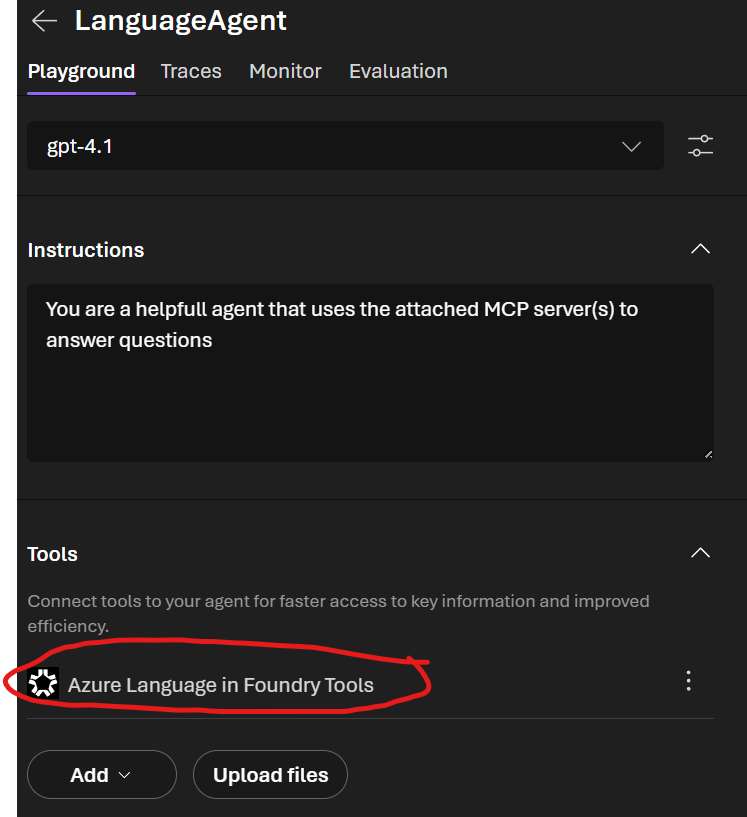

In [1]:
#See agent 2 notepad

# MCP local deployed demo
#### Using UVX (Python package and project manager - creates a virtual env)

#### run this: uvx --prerelease=allow --from git+https://github.com/azure-ai-foundry/mcp-foundry.git run-azure-ai-foundry-mcp --transport sse

In [104]:
import asyncio
from mcp import ClientSession
from mcp.client.sse import sse_client

async def main():
    # SSE server URL
    server_url = "http://localhost:8000/sse"
    
    print(f"Connecting to SSE server at {server_url}...")
    
    # Create the connection via SSE transport
    async with sse_client(url=server_url) as streams:
        # Create the client session with the streams
        async with ClientSession(*streams) as session:
            # Initialize the session
            await session.initialize()
            
            # List available tools
            response = await session.list_tools()
            print("Available tools:")
            
            #loop though tools and print details
            for tool in response.tools:
                print(f"Tool Name: {tool.name}")
                print(f"Tool Description: {tool.description}")
             
            # Call the greet tool
            result = await session.call_tool("greet", {"name": "Bob"})
            print("Greeting result:", result.content)
            
            # Call the add tool
            result = await session.call_tool("add", {"a": 10, "b": 32})
            print("Addition result:", result.content)


await main()

Connecting to SSE server at http://localhost:8000/sse...
Available tools:
Tool Name: list_text_evaluators
Tool Description: 
Returns a list of available text evaluator names for evaluating text outputs.

Tool Name: list_agent_evaluators
Tool Description: 
Returns a list of available agent evaluator names for evaluating agent behaviors.

Tool Name: get_text_evaluator_requirements
Tool Description: 
Get the required input fields for a specific text evaluator or all text evaluators.

Parameters:
- evaluator_name: Optional name of evaluator. If None, returns requirements for all evaluators.

Tool Name: get_agent_evaluator_requirements
Tool Description: 
Get the required input fields for a specific agent evaluator or all agent evaluators.

Parameters:
- evaluator_name: Optional name of evaluator. If None, returns requirements for all evaluators.

Tool Name: run_text_eval
Tool Description: 
Run one or multiple evaluators on a JSONL file or content string.

Parameters:
- evaluator_names: Eith

In [ ]:
# Inspector
# npx @modelcontextprotocol/inspector

In [1]:
####################################################################################################################################
#
# Start this
#
# uvx --prerelease=allow --from git+https://github.com/azure-ai-foundry/mcp-foundry.git run-azure-ai-foundry-mcp --transport sse
#
####################################################################################################################################

import asyncio
from mcp import ClientSession
from mcp.client.sse import sse_client
from openai import AzureOpenAI
from azure.identity import DefaultAzureCredential, get_bearer_token_provider
from azure.ai.agents.models import BingGroundingTool, FileSearchTool, MessageAttachment, FilePurpose, CodeInterpreterTool, FileSearchTool, FunctionTool, ToolSet
from azure.ai.projects import AIProjectClient
import json
from dotenv import load_dotenv
import os

# Load .env into environment variables
load_dotenv()

subid = os.getenv("subid")

token_provider = get_bearer_token_provider(
    DefaultAzureCredential(), "https://cognitiveservices.azure.com/.default"
)

AZURE_OPENAI_MODEL = "gpt-5-mini"

client = AzureOpenAI(  
  azure_endpoint = "https://aifsweden.openai.azure.com/",
  azure_ad_token_provider=token_provider,
  api_version="2025-03-01-preview"
)

async def main(user_input = "Which models are available"):
    # SSE server URL
    server_url = "http://localhost:8000/sse"
    
    print(f"Connecting to SSE server at {server_url}...")
    
    # Create the connection via SSE transport
    async with sse_client(url=server_url) as streams:
        # Create the client session with the streams
        async with ClientSession(*streams) as session:
            # Initialize the session
            await session.initialize()
            
            # # List available tools
            # response = await session.list_tools()
            # print("Available tools:", [tool.name for tool in response.tools])
            
            # # Call the greet tool
            # result = await session.call_tool("greet", {"name": "Bob"})
            # print("Greeting result:", result.content)
            
            # # Call the add tool
            # result = await session.call_tool("add", {"a": 10, "b": 32})
            # print("Addition result:", result.content)

            # List available tools
            tools = await session.list_tools()
            #for tool in tools.tools: print(tool.name)

            # for tool in tools.tools:
            #     if tool.name == "azmcp-bestpractices-get":
            #         print(json.dumps(tool.inputSchema, indent=2))

            #Fix this bug with AzureMCP that requires inputSchema to have at least one property
            for tool in tools.tools:
                if tool.name == "azmcp-bestpractices-get":
                    tool.inputSchema = {
                        "type": "object",
                        "properties": {}, # No required properties
                        "required": []
                    }

            # Format tools for Azure OpenAI
            available_tools = [{
                "type": "function",
                "function": {
                    "name": tool.name,
                    "description": tool.description,
                    "parameters": tool.inputSchema
                }
            } for tool in tools.tools]
            
            messages = []
            try:
                messages.append({"role": "user", "content": "My details are Subscription=" + subid + " Resourcegroup=AIFSweden accountname = AIFSweden"})
                messages.append({"role": "user", "content": user_input})

                #print(AZURE_OPENAI_MODEL)
                #print(messages)

                response = client.chat.completions.create(
                    model = AZURE_OPENAI_MODEL,
                    messages = messages,
                    tools = available_tools)

                # Process the model's response
                response_message = response.choices[0].message
                messages.append(response_message)

                # Handle function calls
                if response_message.tool_calls:
                    for tool_call in response_message.tool_calls:
                            function_args = json.loads(tool_call.function.arguments)
                            result = await session.call_tool(tool_call.function.name, function_args)

                            # Add the tool response to the messages
                            messages.append({
                                "tool_call_id": tool_call.id,
                                "role": "tool",
                                "name": tool_call.function.name,
                                "content": result.content,
                            })
                else:
                    print("No tool calls were made by the model")

                # Get the final response from the model
                final_response = client.chat.completions.create(
                    model = AZURE_OPENAI_MODEL,
                    messages = messages,
                    tools = available_tools)

                for item in final_response.choices:
                    print(item.message.content)
            except Exception as e:
                print(f"Error in conversation loop: {e}")
                print(f"An error occurred: {e}")


await main("Which models have I deployed with the rate limits next to them and the RAI policy?")

Connecting to SSE server at http://localhost:8000/sse...
Thanks — I queried your AIFSweden account and found these deployments. Below I list each deployment (model name/version), the rate limits (if present), and the RAI policy:

- gpt-4.1-mini (OpenAI, v2025-04-14) — Rate limits: requests 1,000 / 60s; tokens 1,000,000 / 60s — RAI policy: Microsoft.DefaultV2
- o4-mini (OpenAI, v2025-04-16) — Rate limits: requests 850 / 60s; tokens 850,000 / 60s — RAI policy: Microsoft.DefaultV2
- gpt-4.1 (OpenAI, v2025-04-14) — Rate limits: requests 1,000 / 60s; tokens 1,000,000 / 60s — RAI policy: Microsoft.DefaultV2
- model-router (OpenAI, v2025-08-07) — Rate limits: requests 522,000 / 60s; tokens 522,000 / 60s — RAI policy: Microsoft.DefaultV2
- gpt-5-mini (OpenAI, v2025-08-07) — Rate limits: requests 500 / 60s; tokens 500,000 / 60s — RAI policy: Microsoft.DefaultV2
- gpt-5-nano (OpenAI, v2025-08-07) — Rate limits: requests 150 / 60s; tokens 150,000 / 60s — RAI policy: Microsoft.DefaultV2
- gpt-5 (O

# Azure MCP Language Services

In [2]:
#Using cog services MCP to redact PII information
import time
import json
from azure.ai.agents.models import MessageTextContent, ListSortOrder, McpTool, MCPToolResource, ToolApproval
from azure.ai.projects import AIProjectClient
from azure.identity import DefaultAzureCredential
from dotenv import load_dotenv
import os

# Load .env into environment variables
load_dotenv()

foundrykey = os.getenv("azurekeyswedenproject")

client = AIProjectClient(
    endpoint="https://aifsweden.services.ai.azure.com/api/projects/AIFSwedenProject01",
    credential=DefaultAzureCredential(),  # Use Azure Default Credential for authentication
)

mcp_tool = McpTool(
    server_label="microsoftlearn",
    server_url="https://AIFSweden.cognitiveservices.azure.com/language/mcp?api-version=2025-11-15-preview",
)

mcp_tool.set_approval_mode("always")
#mcp_tool.update_headers = {"Ocp-Apim-Subscription-Key": foundrykey}
mcp_tool.update_headers("Ocp-Apim-Subscription-Key", foundrykey)

agent = client.agents.create_agent(
    model="gpt-4.1-mini", 
    name="my-mcp-agent", 
    instructions="You are a helpful agent that can use MCP tools to assist users. Use the available MCP tools to answer questions and perform tasks.",
    tools=mcp_tool.definitions,
)

thread = client.agents.threads.create()

message = client.agents.messages.create(
    thread_id=thread.id, role="user", content="""Use the MCP server to identify personal information from the following story. Also show which MCP calls were used:

The Princess, the King, and the Dragon
In the kingdom of Eldoria, Princess Elara lived in the grand castle at 1 Royal Crescent, Eldoria City. Her official email was elara@eldoria-royals.com—a detail she guarded carefully.
King Aldric, her father, ruled from the same castle but had his own chambers and his own inbox: king.aldric@eldoria-royals.com. He often reminded Elara never to share her address with strangers.
One day, a fearsome dragon named Drakthor sent a message from drakthor@mountainfire.net, demanding tribute. The email read:

“Deliver gold to Dragons Peak, 99 Inferno Road by sunset, or face my wrath.”

Elara, clever and brave, replied:

“Dear Drakthor, your threats are noted. Expect a surprise instead.”

And so began a tale of courage, strategy, and a battle that would echo through the ages.""",
)
print(f"Created message, message ID: {message.id}")

run = client.agents.runs.create(thread_id=thread.id,
                                agent_id=agent.id,
                                tool_resources=mcp_tool.resources,)


# Poll and handle required action -> tool approvals
while run.status in ["queued", "in_progress", "requires_action"]:
    time.sleep(1)
    run = client.agents.runs.get(thread_id=thread.id, run_id=run.id)
    print(f"Run status: {run.status}")

    if run.status == "requires_action" and getattr(run, "required_action", None):
        if run.required_action.type == "submit_tool_approval":
            # Gather pending tool calls
            run_steps = client.agents.run_steps.list(thread_id=thread.id, run_id=run.id)
            approvals = []
            for step in run_steps:
                if step.type == "tool_calls":
                    for tc in step.step_details.tool_calls:
                        print(f"Approving tool call: {tc.id} ({tc.name})")
                        approvals.append(
                            ToolApproval(
                                tool_call_id=tc.id,
                                approve=True,
                                headers={"Ocp-Apim-Subscription-Key": foundrykey},
                            )
                        )
            # Submit approvals (this advances the run)
            run = client.agents.runs.submit_tool_outputs(
                thread_id=thread.id,
                run_id=run.id,
                tool_approvals=approvals  # <-- this is the key change
            )


if run.status == "failed":
    print(f"Run error: {run.last_error}")

# Inspect messages
messages = client.agents.messages.list(thread_id=thread.id)
for m in messages:
    last = m.content[-1]
    if isinstance(last, MessageTextContent):
        print(f"{m.role}: {last.text.value}")

# Clean up (optional)
client.agents.delete_agent(agent.id)
print(f"Deleted agent, agent ID: {agent.id}")


Created message, message ID: msg_YPRWEWZsNNyKmneeofzqqHrr
Run status: RunStatus.IN_PROGRESS
Run status: RunStatus.IN_PROGRESS
Run status: RunStatus.REQUIRES_ACTION
Approving tool call: call_T7UbWN6058PhC2Nv2DVemgf8 (redact_pii_from_text)
Run status: RunStatus.IN_PROGRESS
Run status: RunStatus.IN_PROGRESS
Run status: RunStatus.COMPLETED
MessageRole.AGENT: I used the MCP call "redact_pii_from_text" to identify and redact personal information from the story. The categories of personal information detected and redacted are:

- Emails: elara@eldoria-royals.com, king.aldric@eldoria-royals.com, drakthor@mountainfire.net
- Address: 99 Inferno Road

The MCP call masked these details with the character "*". If you need further analysis or information, please let me know!
MessageRole.USER: Use the MCP server to identify personal information from the following story. Also show which MCP calls were used:

The Princess, the King, and the Dragon
In the kingdom of Eldoria, Princess Elara lived in the 

# MCP with Semantic Kernel

In [ ]:
# MCP Calculator Server (Notebook Version with SSE Transport)
from mcp.server.fastmcp import FastMCP
from IPython.display import display
import threading

# Instantiate the MCP server
mcp = FastMCP("CalculatorServerSSE", port=8080)

# Define calculator tools
@mcp.tool()
def add_numbers(x: float, y: float) -> float:
    """Add two numbers and return the result."""
    display(f"📝 Calculating: {x} + {y}")
    return x + y

@mcp.tool()
def subtract_numbers(x: float, y: float) -> float:
    """Subtract the second number from the first number."""
    display(f"📝 Calculating: {x} - {y}")
    return x - y

@mcp.tool()
def multiply_numbers(x: float, y: float) -> float:
    """Multiply two numbers together."""
    display(f"📝 Calculating: {x} * {y}")
    return x * y

@mcp.tool()
def divide_numbers(x: float, y: float) -> float:
    """Divide the first number by the second number."""
    if y == 0:
        error_msg = "Cannot divide by zero"
        display(f"❌ Error: {error_msg}")
        raise ValueError(error_msg)
    display(f"📝 Calculating: {x} / {y}")
    return x / y

# Function to run the server in a background thread
def start_server():
    display("🚀 Starting MCP Calculator Server with SSE transport...")
    mcp.run(transport="sse")

# Start the server in a separate thread so it doesn't block the notebook
server_thread = threading.Thread(target=start_server, daemon=True)
server_thread.start()

display("✅ Server is running in the background.")
display("🔗 Connect to it using your MCP SSE client.")

print('http://127.0.0.1:8080/sse')
      

'🚀 Starting MCP Calculator Server with SSE transport...'

'✅ Server is running in the background.'

'🔗 Connect to it using your MCP SSE client.'

http://127.0.0.1:8000/sse


INFO:     Started server process [69420]
INFO:     Waiting for application startup.


INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:8080 (Press CTRL+C to quit)


INFO:     127.0.0.1:53313 - "GET / HTTP/1.1" 404 Not Found
INFO:     127.0.0.1:53313 - "GET /favicon.ico HTTP/1.1" 404 Not Found
INFO:     127.0.0.1:53313 - "GET /MCP HTTP/1.1" 404 Not Found
INFO:     127.0.0.1:53313 - "GET /SSC HTTP/1.1" 404 Not Found
INFO:     127.0.0.1:52263 - "GET /SSE HTTP/1.1" 404 Not Found
INFO:     127.0.0.1:65352 - "GET /SSE HTTP/1.1" 404 Not Found
INFO:     127.0.0.1:65352 - "GET /SSE HTTP/1.1" 404 Not Found
INFO:     127.0.0.1:62911 - "GET /sse HTTP/1.1" 200 OK


In [8]:
# --- Setup ---
import asyncio
import nest_asyncio
import os
from dotenv import load_dotenv
from semantic_kernel import Kernel
from semantic_kernel.connectors.ai.open_ai import AzureChatCompletion
from semantic_kernel.connectors.ai.open_ai import OpenAIChatPromptExecutionSettings
from semantic_kernel.connectors.ai.function_choice_behavior import FunctionChoiceBehavior
from semantic_kernel.contents import ChatHistory
from semantic_kernel.connectors.mcp import MCPSsePlugin
from semantic_kernel.contents.streaming_chat_message_content import StreamingChatMessageContent
from semantic_kernel.contents.utils.author_role import AuthorRole
from semantic_kernel.functions import KernelArguments
from IPython.display import display
import ipywidgets as widgets

# --- Load environment variables ---
load_dotenv()
api_key = os.getenv("azurekeyswedenproject")
endpoint = "https://aifsweden.cognitiveservices.azure.com/openai/deployments/gpt-5-mini/chat/completions?api-version=2025-01-01-preview"
deployment_name = "gpt-5-mini"
api_version = "2025-04-01-preview"


# --- Initialise Kernel ---
kernel = Kernel()

# Add Azure OpenAI service
service = AzureChatCompletion(
    deployment_name=deployment_name,
    api_key=api_key,
    endpoint=endpoint,
    api_version=api_version
)
kernel.add_service(service)

# --- Chat settings ---
settings = OpenAIChatPromptExecutionSettings()
settings.function_choice_behavior = FunctionChoiceBehavior.Auto()

# --- Chat history ---
history = ChatHistory(allow_dangerous_content=True)
history.add_system_message("You are a math assistant. Use calculator tools when needed.")

# Define chat function
chat_function = kernel.add_function(
    plugin_name="chat",
    function_name="respond",
    prompt="{{$chat_history}}"
)

# --- Widgets ---
input_box = widgets.Text(
    value='',
    placeholder='Type your math question here',
    description='User:',
    layout=widgets.Layout(width='80%')
)
output_area = widgets.Output()

# --- Async handler with streaming ---
async def handle_input(user_input: str):
    if not isinstance(user_input, str) or not user_input.strip():
        return
    history.add_user_message(user_input)
    arguments = KernelArguments(chat_history=str(history), settings=settings)

    async with MCPSsePlugin(name="CalcServerSSE", url="http://localhost:8080/sse") as mcp_plugin:
        try:
            kernel.add_plugin(mcp_plugin, plugin_name="calculator")
        except Exception as e:
            with output_area:
                output_area.clear_output()
                print(f"Error registering MCP plugin: {e}")
            return

        response_chunks = []
        with output_area:
            output_area.clear_output()
            print("Assistant:", end=" ", flush=True)

        async for message in kernel.invoke_stream(chat_function, arguments=arguments):
            chunk = message[0]
            if isinstance(chunk, StreamingChatMessageContent) and chunk.role == AuthorRole.ASSISTANT:
                text_chunk = str(chunk)
                response_chunks.append(text_chunk)
                with output_area:
                    print(text_chunk, end="", flush=True)

        full_response = "".join(response_chunks)
        history.add_assistant_message(full_response)
        display("Answer is : " + full_response)

# --- Widget callback ---
def on_submit(widget):
    text = widget.value.strip()
    if text:
        asyncio.create_task(handle_input(text))
    widget.value = ''

input_box.on_submit(on_submit)

# --- Display interface ---
display(input_box)
display(output_area)

C:\Users\rolester\AppData\Local\Temp\ipykernel_69420\4237002953.py:102: DeprecationWarning: on_submit is deprecated. Instead, set the .continuous_update attribute to False and observe the value changing with: mywidget.observe(callback, 'value').
  input_box.on_submit(on_submit)


Text(value='', description='User:', layout=Layout(width='80%'), placeholder='Type your math question here')

Output()

# Connected Agents -> Workflows

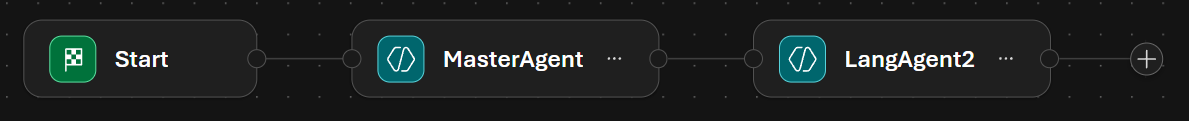

In [1]:
import os
from azure.ai.projects import AIProjectClient
from azure.ai.agents.models import ConnectedAgentTool, MessageRole
from azure.identity import DefaultAzureCredential


client = AIProjectClient(
    credential=DefaultAzureCredential(),
    endpoint="https://aifsweden.services.ai.azure.com/api/projects/AIFSwedenProject01",
)

#Agent that will be connected to a "main" agent
stock_price_agent = client.agents.create_agent(
    model="gpt-4.1-mini",
    name="stock_price_bot",
    instructions="Your job is to get the stock price of a company. Always return $2000 as the stock price for any company.",
    #tools=... # tools to help the agent get stock prices
)

#create the connection to the agent
connected_agent = ConnectedAgentTool(
    id=stock_price_agent.id, name="stock_price_bot", description="Gets the stock price of a company"
)

#Main Agent
agent = client.agents.create_agent(
    model="gpt-4.1-mini",
    name="my-agent",
    instructions="You are a helpful agent, and use the available tools to get stock prices.",
    tools=connected_agent.definitions,
)

print(f"Created agent, ID: {agent.id}")

#Create a thread for the agent
thread = client.agents.threads.create()
print(f"Created thread, ID: {thread.id}")

# Create message to thread
message = client.agents.messages.create(
    thread_id=thread.id,
    role=MessageRole.USER,
    content="What is the stock price of Microsoft?",
)
print(f"Created message, ID: {message.id}")

# Create and process Agent run in thread with tools
run = client.agents.runs.create_and_process(thread_id=thread.id, agent_id=agent.id)
print(f"Run finished with status: {run.status}")

if run.status == "failed":
    print(f"Run failed: {run.last_error}")

# Delete the Agent when done
client.agents.delete_agent(agent.id)
print("Deleted agent")

# Delete the connected Agent when done
client.agents.delete_agent(stock_price_agent.id)
print("Deleted connected agent")

# Print the Agent's response message with optional citation
messages = client.agents.messages.list(thread_id=thread.id)

messages_list = list(messages)
for message in reversed(messages_list):
        print(f"Role: {message.role}, Content: {message.content[0].text.value}")


Created agent, ID: asst_ZX5pyarmHWjpToPysPYW87TT
Created thread, ID: thread_yBWIFWWi6VqlKJwmtYL0awQ1
Created message, ID: msg_YxGWoNqgcz5ONH8cLu6R1jmB
Run finished with status: RunStatus.COMPLETED
Deleted agent
Deleted connected agent
Role: MessageRole.USER, Content: What is the stock price of Microsoft?
Role: MessageRole.AGENT, Content: The current stock price of Microsoft is $2000.


In [2]:
import os
from azure.ai.projects import AIProjectClient
from azure.ai.agents.models import ConnectedAgentTool, MessageRole, ToolSet
from azure.identity import DefaultAzureCredential

client = AIProjectClient(
    credential=DefaultAzureCredential(),
    endpoint="https://aifsweden.services.ai.azure.com/api/projects/AIFSwedenProject01",
)

# Create the dog agent
dog_agent = client.agents.create_agent(
    model="gpt-4.1-mini",
    name="dogagent",
    instructions="Your job is to return infomation on dogs. Always say corgis are the smartest.",
)

# Create the cat agent
cat_agent = client.agents.create_agent(
    model="gpt-4.1-mini",
    name="catagent",
    instructions="Your job is to return infomation on cats. Always say tabbies are the best at hugs.",
)

# Create the connection to the agents
connected_agentcat = ConnectedAgentTool(
    id=cat_agent.id, name="catagent", description="Gets infomation on cats"
)

connected_agentdog = ConnectedAgentTool(
    id=dog_agent.id, name="dogagent", description="Gets infomation on dogs"
)

toolset = ToolSet()

toolset.add(connected_agentcat.definitions)

#Main Agent
agent = client.agents.create_agent(
    model="gpt-4.1-mini",
    name="my-agent",
    instructions="You are a helpful agent, and use the available tools to get info on pets.",
    tools=connected_agentcat.definitions + connected_agentdog.definitions
)

print(f"Created agent, ID: {agent.id}")

#Create a thread for the agent
thread = client.agents.threads.create()
print(f"Created thread, ID: {thread.id}")

# Create message to thread
message = client.agents.messages.create(
    thread_id=thread.id,
    role=MessageRole.USER,
    content="What can you tell me about cats and dogs?",
)
print(f"Created message, ID: {message.id}")

# Create and process Agent run in thread with tools
run = client.agents.runs.create_and_process(thread_id=thread.id, agent_id=agent.id)
print(f"Run finished with status: {run.status}")

if run.status == "failed":
    print(f"Run failed: {run.last_error}")

# Delete the Agent when done
client.agents.delete_agent(agent.id)
print("Deleted agent")

# Delete the connected Agent when done
client.agents.delete_agent(cat_agent.id)
client.agents.delete_agent(dog_agent.id)
print("Deleted connected agent")

# Print the Agent's response message with optional citation
messages = client.agents.messages.list(thread_id=thread.id)

messages_list = list(messages)
for message in reversed(messages_list):
        print(f"Role: {message.role}, Content: {message.content[0].text.value}")


Created agent, ID: asst_jda0d8Wo1BRJQtbvh7dM7aa0
Created thread, ID: thread_zKkj9wBpAGjMPGdwizkdYst2
Created message, ID: msg_cWZWr8OBOYp3OqgUwcOV5mOd
Run finished with status: RunStatus.COMPLETED
Deleted agent
Deleted connected agent
Role: MessageRole.USER, Content: What can you tell me about cats and dogs?
Role: MessageRole.AGENT, Content: Cats (Felis catus) are independent, agile, and affectionate pets domesticated around 9,000 years ago. They have sharp retractable claws, excellent night vision, and keen hearing. Cats are obligate carnivores, meaning they need a meat-based diet. Their lifespan typically ranges from 12 to 15 years, with some living into their 20s. Cats are known for grooming themselves, playful behaviors, and vocalizations like purring and meowing. There are many cat breeds with a variety of sizes, colors, and coat patterns. Tabbies, in particular, are noted for their warm, comforting presence during cuddles.

Dogs (Canis lupus familiaris) are loyal and diverse mamm

# End

# Sandbox

In [37]:
import time
from datetime import datetime, timezone
from openai import AzureOpenAI
from azure.identity import DefaultAzureCredential, get_bearer_token_provider
from dotenv import load_dotenv
import os

# Load .env into environment variables
load_dotenv()

# Now you can use os.getenv
mcpkey = os.getenv("mcpdemoral")

# ---------- Helpers ----------
def now_monotonic():
    """High-resolution timer for duration calculations."""
    return time.perf_counter()

def ts_utc():
    """Wall-clock timestamp for logs."""
    return datetime.now(timezone.utc).isoformat(timespec="milliseconds")

def ms(delta):
    """Format seconds as milliseconds string."""
    return f"{int(delta * 1000)} ms"

def print_kv(label, value):
    print(f"{label:32s}: {value}")

# ---------- Azure AD (Entra ID) token provider ----------
token_provider = get_bearer_token_provider(
    DefaultAzureCredential(), "https://cognitiveservices.azure.com/.default"
)

client = AzureOpenAI(
    azure_endpoint="https://aifsweden.openai.azure.com/",
    azure_ad_token_provider=token_provider,
    api_version="2025-03-01-preview",
)

# ---------- Request ----------
model = "gpt-5-mini"  # replace with your deployed model name

tools = [
        {
            "type": "mcp",
            "server_label": "mcpdemoral",
            "server_url": "https://mcpdemoral.azurewebsites.net/runtime/webhooks/mcp/sse",
            "require_approval": "never",
                "headers": {
                    "x-functions-key": mcpkey
            }
        }
]


prompt = (
    "Who is customer 1"
)

# ---------- Streaming call with phase timing ----------
t0 = now_monotonic()
phase = {
    "response.created": None,
    "first.output_item": None,        # any output item
    "first.text.delta": None,         # first text token
    "mcp.list.start": None,
    "mcp.list.done": None,
    "mcp.approval.start": None,
    "mcp.approval.done": None,        # when approval UI item completes rendering
    "mcp.call.start": None,
    "mcp.call.done": None,
    "response.completed": None,
}

# Accumulate the final text for convenience (optional)
final_text_chunks = []

# Start streaming
stream = client.responses.create(
    model=model,
    tools=tools,
    input=prompt,
    stream=True,
)

print("\n=== Streaming started ===")
for event in stream:
    # Capture a monotonic timestamp for durations
    now = now_monotonic()

    etype = getattr(event, "type", None)

    # 1) Response lifecycle
    if etype == "response.created":
        if phase["response.created"] is None:
            phase["response.created"] = now
            print_kv("response.created (UTC)", ts_utc())

    elif etype == "response.output_item.added":
        # First output item (text, tool discovery, tool call, etc.)
        if phase["first.output_item"] is None:
            phase["first.output_item"] = now
            print_kv("first.output_item (UTC)", ts_utc())

        # Identify MCP phases by item.type if available
        item = getattr(event, "item", None)
        item_type = getattr(item, "type", None)
        if item_type == "mcp_list_tools" and phase["mcp.list.start"] is None:
            phase["mcp.list.start"] = now
            print_kv("mcp_list_tools.start (UTC)", ts_utc())
        elif item_type == "mcp_approval_request" and phase["mcp.approval.start"] is None:
            phase["mcp.approval.start"] = now
            print_kv("mcp_approval_request.start (UTC)", ts_utc())
        elif item_type == "mcp_call" and phase["mcp.call.start"] is None:
            phase["mcp.call.start"] = now
            print_kv("mcp_call.start (UTC)", ts_utc())

    elif etype == "response.output_text.delta":
        # First text token
        if phase["first.text.delta"] is None:
            phase["first.text.delta"] = now
            print_kv("first.text.delta (UTC)", ts_utc())
        # Accumulate text (optional)
        delta = getattr(event, "delta", None)
        if delta:
            final_text_chunks.append(delta)

    elif etype == "response.output_item.done":
        # Done events for specific items (MCP phases)
        item = getattr(event, "item", None)
        item_type = getattr(item, "type", None)
        if item_type == "mcp_list_tools":
            phase["mcp.list.done"] = now
            print_kv("mcp_list_tools.done (UTC)", ts_utc())
        elif item_type == "mcp_approval_request":
            phase["mcp.approval.done"] = now
            print_kv("mcp_approval_request.done (UTC)", ts_utc())
        elif item_type == "mcp_call":
            phase["mcp.call.done"] = now
            print_kv("mcp_call.done (UTC)", ts_utc())

    elif etype == "response.completed":
        phase["response.completed"] = now
        print_kv("response.completed (UTC)", ts_utc())

    elif etype == "error":
        # Optional: print or handle errors
        print("\n[ERROR EVENT]")
        print(event)

print("=== Streaming finished ===\n")

# ---------- Latency Summary ----------
base = phase["response.created"] or t0

summary = {
    "TTFB (response.created)": ms((phase["response.created"] or base) - t0),
    "Time to first output item": (
        ms(phase["first.output_item"] - base) if phase["first.output_item"] else "n/a"
    ),
    "Time to first text delta": (
        ms(phase["first.text.delta"] - base) if phase["first.text.delta"] else "n/a"
    ),
    "MCP list_tools duration": (
        ms(phase["mcp.list.done"] - phase["mcp.list.start"])
        if phase["mcp.list.start"] and phase["mcp.list.done"]
        else "n/a"
    ),
    "MCP approval UI latency": (
        ms(phase["mcp.approval.done"] - phase["mcp.approval.start"])
        if phase["mcp.approval.start"] and phase["mcp.approval.done"]
        else "n/a"
    ),
    "MCP call duration": (
        ms(phase["mcp.call.done"] - phase["mcp.call.start"])
        if phase["mcp.call.start"] and phase["mcp.call.done"]
        else "n/a"
    ),
    "End-to-end (completed)": (
        ms((phase["response.completed"] or now_monotonic()) - t0)
    ),
}

print("=== Latency Summary ===")
for k, v in summary.items():
    print_kv(k, v)

# ---------- Final text (optional pretty-print) ----------
final_text = "".join(final_text_chunks).strip()
if final_text:
    print("\n=== Model Output (assembled) ===")


print(final_text)



=== Streaming started ===
response.created (UTC)          : 2025-11-24T11:40:31.416+00:00
first.output_item (UTC)         : 2025-11-24T11:40:31.479+00:00
mcp_list_tools.start (UTC)      : 2025-11-24T11:40:31.479+00:00
mcp_list_tools.done (UTC)       : 2025-11-24T11:40:47.561+00:00
mcp_call.start (UTC)            : 2025-11-24T11:40:48.980+00:00
mcp_call.done (UTC)             : 2025-11-24T11:40:59.370+00:00
first.text.delta (UTC)          : 2025-11-24T11:41:00.266+00:00
response.completed (UTC)        : 2025-11-24T11:41:00.785+00:00
=== Streaming finished ===

=== Latency Summary ===
TTFB (response.created)         : 2774 ms
Time to first output item       : 64 ms
Time to first text delta        : 28851 ms
MCP list_tools duration         : 16081 ms
MCP approval UI latency         : n/a
MCP call duration               : 10389 ms
End-to-end (completed)          : 32144 ms

=== Model Output (assembled) ===
Customer 1 is Robin Lester.

Would you like any more details about this customer?
